# Teste: Feature Engineering (Trilha I)

Este notebook testa os módulos implementados em `src/features/`:
- `returns.py` - Cálculo de retornos
- `volatility.py` - ATR e volatilidade rolling
- `zscore.py` - Z-Score e sinais
- `alignment.py` - Alinhamento temporal

**Critérios de sucesso:**
- Retornos calculados corretamente
- Volatilidade sem erros
- Z-Score entre -3 e +3 na maioria
- Sinais gerados quando |z| > 1.5

## 1. Setup e Imports

In [1]:
import sys
from pathlib import Path

# Adiciona raiz do projeto ao path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports dos módulos de features
from src.features import (
    # Returns
    calculate_returns,
    add_return_features,
    calculate_momentum,
    calculate_lagged_returns,
    # Volatility
    calculate_atr,
    calculate_rolling_std,
    add_volatility_features,
    calculate_volatility_ratio,
    # Z-Score
    calculate_zscore,
    calculate_zscore_threshold,
    add_zscore_features,
    is_extreme_move,
    # Alignment
    create_analysis_dataset,
    validate_alignment,
    add_lagged_features,
    calculate_lead_lag_correlation,
)

print("✅ Todos os imports funcionaram!")

✅ Todos os imports funcionaram!


## 2. Carregar Dados do Supabase

In [3]:
from jobs.clients.supabase_client import get_supabase_client

client = get_supabase_client()

def fetch_all_records(table_name: str, order_by: str = 'timestamp') -> pd.DataFrame:
    """Busca TODOS os registros de uma tabela usando paginação."""
    all_data = []
    page_size = 1000
    offset = 0
    
    while True:
        response = (client.client.table(table_name)
                    .select('*')
                    .order(order_by)
                    .range(offset, offset + page_size - 1)
                    .execute())
        
        if not response.data:
            break
            
        all_data.extend(response.data)
        
        if len(response.data) < page_size:
            break
            
        offset += page_size
    
    return pd.DataFrame(all_data)

# Carrega dados
print("Carregando dados...")
vale3_df = fetch_all_records('prices_vale3')
iron_df = fetch_all_records('prices_iron_ore')
aux_df = fetch_all_records('auxiliary_data')

print(f"VALE3: {len(vale3_df)} registros")
print(f"Minério: {len(iron_df)} registros")
print(f"Auxiliar: {len(aux_df)} registros")

Carregando dados...
VALE3: 1758 registros
Minério: 1300 registros
Auxiliar: 1305 registros


## 3. Preparar DataFrames

In [4]:
# Converte timestamps
vale3_df['timestamp'] = pd.to_datetime(vale3_df['timestamp'], format='ISO8601')
iron_df['timestamp'] = pd.to_datetime(iron_df['timestamp'], format='ISO8601')
aux_df['timestamp'] = pd.to_datetime(aux_df['timestamp'], format='ISO8601')

# Extrai data (ignora hora)
vale3_df['date'] = vale3_df['timestamp'].dt.date
iron_df['date'] = iron_df['timestamp'].dt.date
aux_df['date'] = aux_df['timestamp'].dt.date

# Converte para datetime
vale3_df['date'] = pd.to_datetime(vale3_df['date'])
iron_df['date'] = pd.to_datetime(iron_df['date'])
aux_df['date'] = pd.to_datetime(aux_df['date'])

# Minério: agrupa por data (SZZFc2 é rolling chain)
iron_daily = iron_df.groupby('date').last().reset_index()

# VALE3: agrupa por data
vale3_daily = vale3_df.groupby('date').last().reset_index()

# Auxiliar: agrupa por data
aux_daily = aux_df.groupby('date').last().reset_index()

print(f"Minério diário: {len(iron_daily)} registros")
print(f"VALE3 diário: {len(vale3_daily)} registros")
print(f"Auxiliar diário: {len(aux_daily)} registros")

Minério diário: 1300 registros
VALE3 diário: 1247 registros
Auxiliar diário: 1305 registros


## 4. Teste: Alinhamento Temporal (alignment.py)

In [5]:
print("="*60)
print("TESTE: ALINHAMENTO TEMPORAL")
print("="*60)

# Prepara DataFrames para create_analysis_dataset
iron_for_align = iron_daily[['date', 'price']].copy()
vale3_for_align = vale3_daily[['date', 'close']].copy()

# Adiciona colunas extras se disponíveis
for col in ['open', 'high', 'low', 'volume']:
    if col in vale3_daily.columns:
        vale3_for_align[col] = vale3_daily[col]

aux_for_align = aux_daily[['date', 'usd_brl', 'vix']].copy() if 'vix' in aux_daily.columns else aux_daily[['date', 'usd_brl']].copy()

# Cria dataset alinhado
df = create_analysis_dataset(
    iron_ore_df=iron_for_align,
    vale3_df=vale3_for_align,
    auxiliary_df=aux_for_align,
    iron_price_col='price',
    vale_price_col='close',
    date_col='date'
)

print(f"\nDataset alinhado: {len(df)} registros")
print(f"Período: {df.index.min().date()} a {df.index.max().date()}")
print(f"\nColunas: {list(df.columns)}")

# Valida alinhamento
validation = validate_alignment(df)
print(f"\nValidação:")
print(f"  Gaps > 3 dias: {validation['date_gaps']}")
print(f"  Missing (%):", {k: v for k, v in validation['missing_pct'].items() if v > 0})

df.head()

2026-01-16 18:53:39.839 | INFO     | src.features.alignment:create_analysis_dataset:222 - Dataset de análise criado: 1247 registros, 2021-01-18 a 2026-01-16


TESTE: ALINHAMENTO TEMPORAL

Dataset alinhado: 1247 registros
Período: 2021-01-18 a 2026-01-16

Colunas: ['iron_ore_price', 'vale3_close', 'vale3_open', 'vale3_high', 'vale3_low', 'vale3_volume', 'usd_brl', 'vix']

Validação:
  Gaps > 3 dias: 21
  Missing (%): {'vix': np.float64(0.08)}


,iron_ore_price,vale3_close,vale3_open,vale3_high,vale3_low,vale3_volume,usd_brl,vix
2021-01-18,170.26,54.51,54.27,55.28,54.07,22667600.0,5.2913,NaN
2021-01-19,167.03,54.36,54.62,54.66,53.11,27155400.0,5.2948,23.24
2021-01-20,165.97,53.36,54.91,54.99,52.50,20480000.0,5.3567,21.58
2021-01-21,167.60,53.96,53.34,55.54,53.25,25983400.0,5.2905,21.32
2021-01-22,166.14,53.85,53.17,54.22,52.59,25814300.0,5.3495,21.91


## 5. Teste: Retornos (returns.py)

In [6]:
print("="*60)
print("TESTE: RETORNOS")
print("="*60)

# Adiciona features de retorno - Minério
df = add_return_features(
    df, 
    'iron_ore_price', 
    prefix='iron_', 
    periods=[1, 5, 10, 20],
    include_momentum=True,
    include_cumulative=True
)

# Adiciona features de retorno - VALE3
df = add_return_features(
    df, 
    'vale3_close', 
    prefix='vale3_', 
    periods=[1, 5, 10, 20],
    include_momentum=True,
    include_cumulative=True
)

# Lista colunas de retorno criadas
return_cols = [c for c in df.columns if 'return' in c or 'momentum' in c or 'cumulative' in c]
print(f"\nColunas de retorno criadas ({len(return_cols)}):")
for col in sorted(return_cols):
    print(f"  - {col}")

# Estatísticas dos retornos diários
print(f"\nEstatísticas - Retorno Diário (1d):")
print(df[['iron_return_1d', 'vale3_return_1d']].describe())

# Correlação dos retornos
corr = df['iron_return_1d'].corr(df['vale3_return_1d'])
print(f"\n✅ Correlação retornos (minério x VALE3): {corr:.4f}")

2026-01-16 18:53:45.837 | DEBUG    | src.features.returns:calculate_returns:59 - Calculados retornos para períodos: [1, 5, 10, 20]
2026-01-16 18:53:45.849 | DEBUG    | src.features.returns:add_return_features:151 - Adicionadas features de retorno para 'iron_ore_price'
2026-01-16 18:53:45.867 | DEBUG    | src.features.returns:calculate_returns:59 - Calculados retornos para períodos: [1, 5, 10, 20]
2026-01-16 18:53:45.878 | DEBUG    | src.features.returns:add_return_features:151 - Adicionadas features de retorno para 'vale3_close'


TESTE: RETORNOS

Colunas de retorno criadas (12):
  - iron_cumulative_return_20d
  - iron_momentum_5_20
  - iron_return_10d
  - iron_return_1d
  - iron_return_20d
  - iron_return_5d
  - vale3_cumulative_return_20d
  - vale3_momentum_5_20
  - vale3_return_10d
  - vale3_return_1d
  - vale3_return_20d
  - vale3_return_5d

Estatísticas - Retorno Diário (1d):
       iron_return_1d  vale3_return_1d
count     1246.000000      1246.000000
mean        -0.006837         0.046966
std          2.462941         1.867135
min        -12.443014        -7.585926
25%         -1.270050        -1.035514
50%          0.044635        -0.021758
75%          1.268927         0.989865
max         14.976516        10.404624

✅ Correlação retornos (minério x VALE3): 0.4355


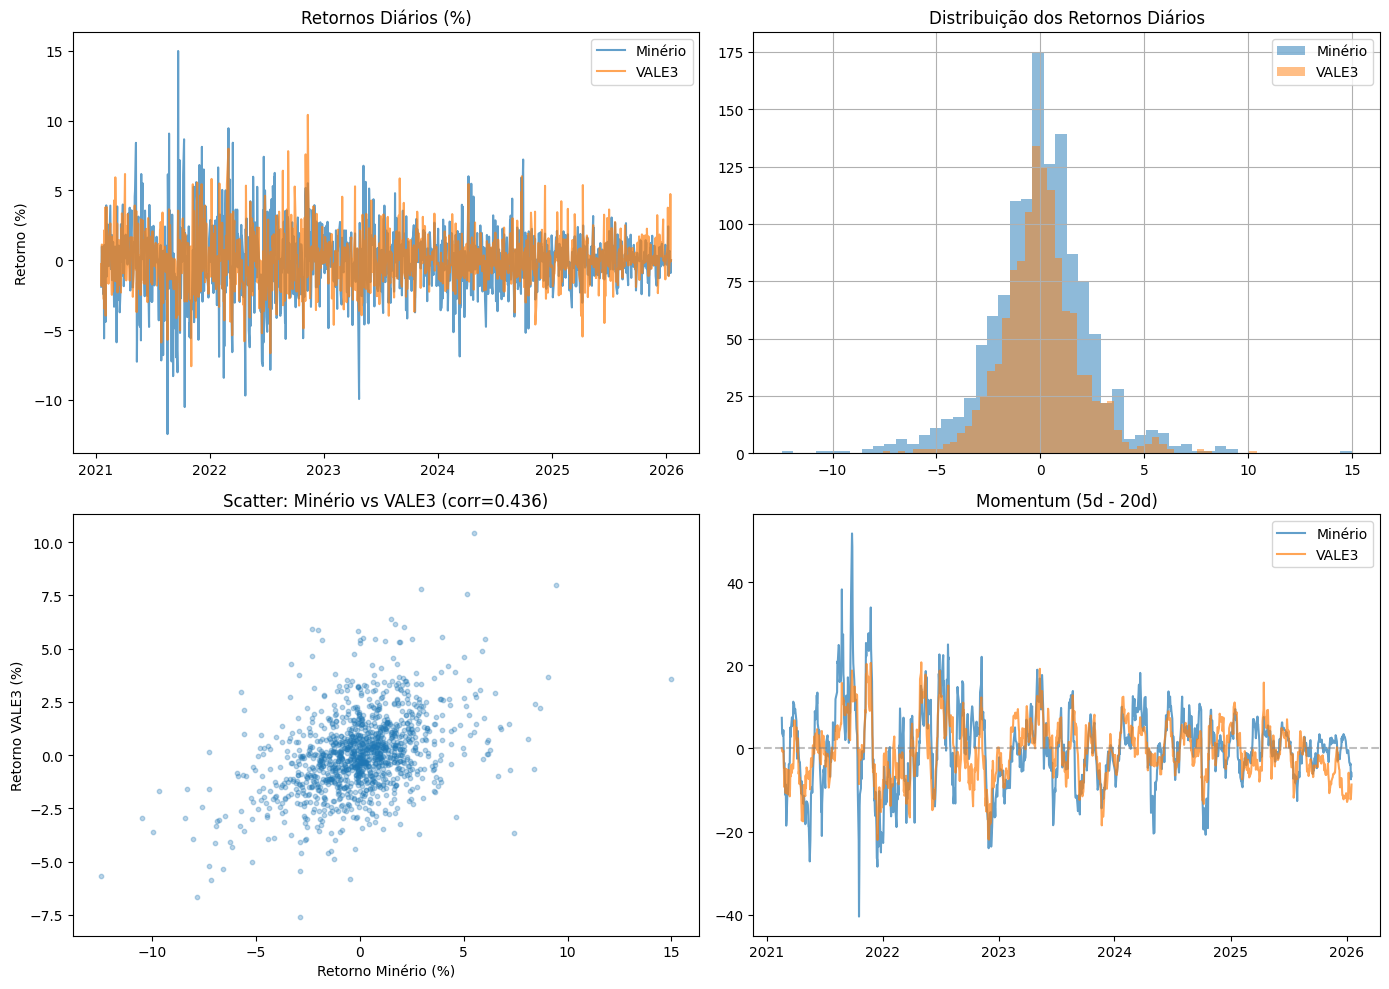

✅ Retornos calculados corretamente!


In [7]:
# Visualização dos retornos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Retornos ao longo do tempo
ax1 = axes[0, 0]
ax1.plot(df.index, df['iron_return_1d'], label='Minério', alpha=0.7)
ax1.plot(df.index, df['vale3_return_1d'], label='VALE3', alpha=0.7)
ax1.set_title('Retornos Diários (%)')
ax1.legend()
ax1.set_ylabel('Retorno (%)')

# Histograma dos retornos
ax2 = axes[0, 1]
df['iron_return_1d'].hist(bins=50, ax=ax2, alpha=0.5, label='Minério')
df['vale3_return_1d'].hist(bins=50, ax=ax2, alpha=0.5, label='VALE3')
ax2.set_title('Distribuição dos Retornos Diários')
ax2.legend()

# Scatter plot
ax3 = axes[1, 0]
ax3.scatter(df['iron_return_1d'], df['vale3_return_1d'], alpha=0.3, s=10)
ax3.set_xlabel('Retorno Minério (%)')
ax3.set_ylabel('Retorno VALE3 (%)')
ax3.set_title(f'Scatter: Minério vs VALE3 (corr={corr:.3f})')

# Momentum
ax4 = axes[1, 1]
ax4.plot(df.index, df['iron_momentum_5_20'], label='Minério', alpha=0.7)
ax4.plot(df.index, df['vale3_momentum_5_20'], label='VALE3', alpha=0.7)
ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax4.set_title('Momentum (5d - 20d)')
ax4.legend()

plt.tight_layout()
plt.show()

print("✅ Retornos calculados corretamente!")

## 6. Teste: Volatilidade (volatility.py)

In [8]:
print("="*60)
print("TESTE: VOLATILIDADE")
print("="*60)

# Volatilidade para Minério (só tem close)
df = add_volatility_features(
    df,
    'iron_ore_price',
    prefix='iron_',
    windows=[5, 10, 20],
    include_atr=False,  # Não tem OHLC
    include_ratio=True
)

# Volatilidade para VALE3
has_ohlc = 'vale3_high' in df.columns and 'vale3_low' in df.columns
df = add_volatility_features(
    df,
    'vale3_close',
    high_col='vale3_high' if has_ohlc else None,
    low_col='vale3_low' if has_ohlc else None,
    prefix='vale3_',
    windows=[5, 10, 20],
    include_atr=has_ohlc,
    include_ratio=True
)

# Lista colunas de volatilidade
vol_cols = [c for c in df.columns if 'volatility' in c or 'atr' in c or 'vol_ratio' in c]
print(f"\nColunas de volatilidade criadas ({len(vol_cols)}):")
for col in sorted(vol_cols):
    print(f"  - {col}")

# Estatísticas
print(f"\nEstatísticas - Volatilidade 20d:")
print(df[['iron_volatility_20d', 'vale3_volatility_20d']].describe())

2026-01-16 18:54:09.861 | DEBUG    | src.features.volatility:calculate_rolling_std:141 - Calculada volatilidade rolling para janelas: [5, 10, 20]
2026-01-16 18:54:09.871 | DEBUG    | src.features.volatility:add_volatility_features:248 - Adicionadas features de volatilidade para 'iron_ore_price'
2026-01-16 18:54:09.884 | DEBUG    | src.features.volatility:calculate_rolling_std:141 - Calculada volatilidade rolling para janelas: [5, 10, 20]
2026-01-16 18:54:09.905 | DEBUG    | src.features.volatility:calculate_atr:86 - Calculado ATR(14)
2026-01-16 18:54:09.917 | DEBUG    | src.features.volatility:calculate_atr:86 - Calculado ATR(20)
2026-01-16 18:54:09.928 | DEBUG    | src.features.volatility:add_volatility_features:248 - Adicionadas features de volatilidade para 'vale3_close'


TESTE: VOLATILIDADE

Colunas de volatilidade criadas (12):
  - iron_vol_ratio_5_20
  - iron_volatility_10d
  - iron_volatility_20d
  - iron_volatility_5d
  - vale3_atr_14
  - vale3_atr_20
  - vale3_atr_pct_14
  - vale3_atr_pct_20
  - vale3_vol_ratio_5_20
  - vale3_volatility_10d
  - vale3_volatility_20d
  - vale3_volatility_5d

Estatísticas - Volatilidade 20d:
       iron_volatility_20d  vale3_volatility_20d
count          1227.000000           1227.000000
mean              2.242376              1.766266
std               1.044332              0.602536
min               0.665717              0.391655
25%               1.478988              1.295795
50%               1.977157              1.745855
75%               2.755975              2.141789
max               6.117492              3.734405


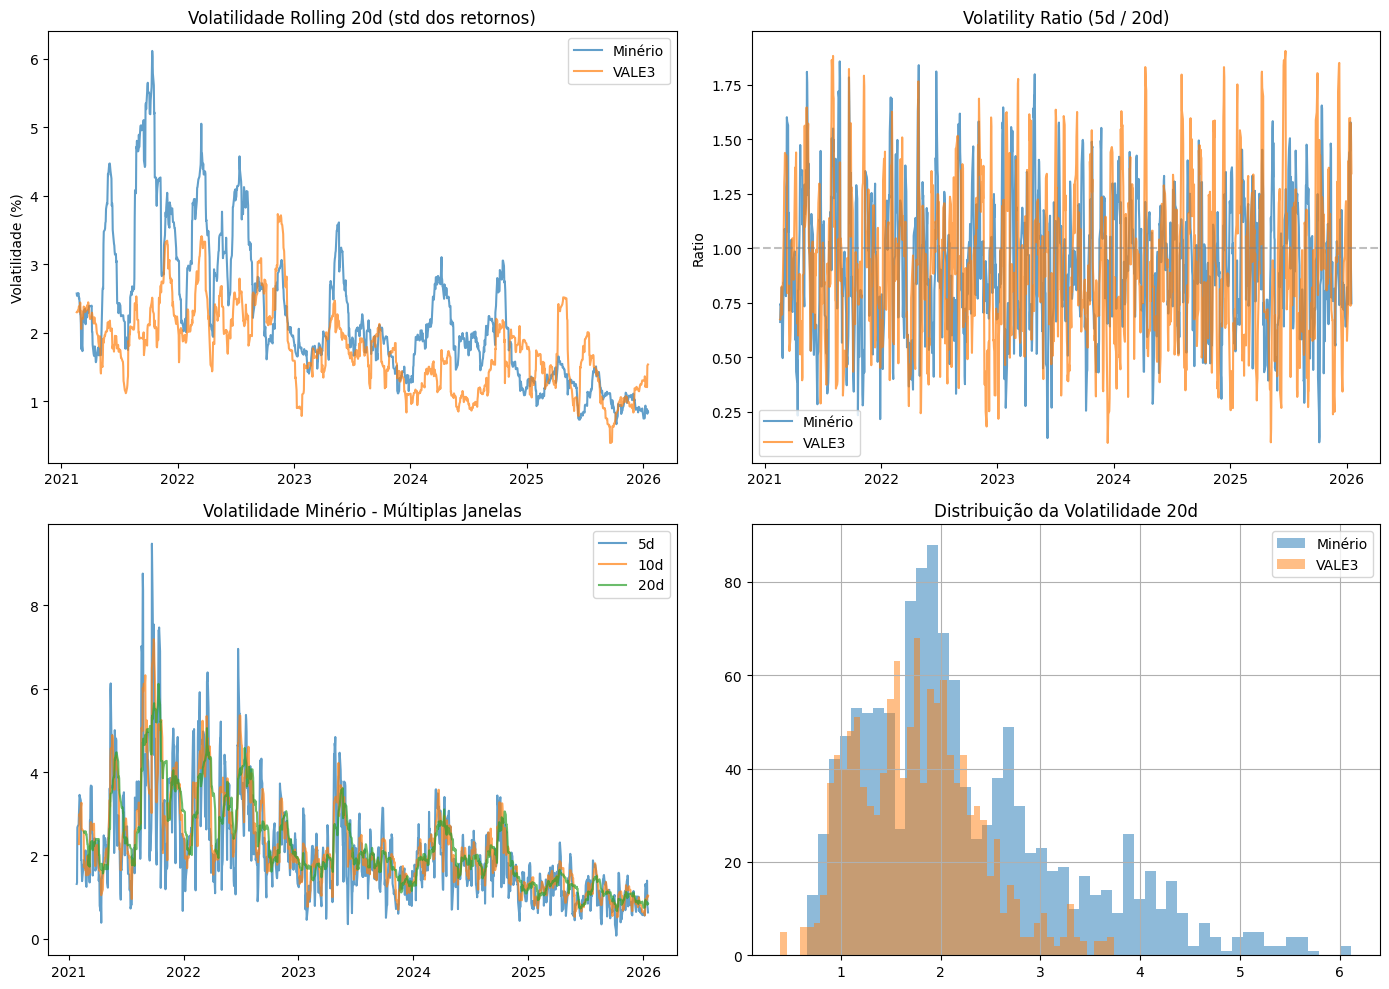

✅ Volatilidade calculada corretamente!


In [9]:
# Visualização da volatilidade
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Volatilidade ao longo do tempo
ax1 = axes[0, 0]
ax1.plot(df.index, df['iron_volatility_20d'], label='Minério', alpha=0.7)
ax1.plot(df.index, df['vale3_volatility_20d'], label='VALE3', alpha=0.7)
ax1.set_title('Volatilidade Rolling 20d (std dos retornos)')
ax1.legend()
ax1.set_ylabel('Volatilidade (%)')

# Volatility Ratio
ax2 = axes[0, 1]
ax2.plot(df.index, df['iron_vol_ratio_5_20'], label='Minério', alpha=0.7)
ax2.plot(df.index, df['vale3_vol_ratio_5_20'], label='VALE3', alpha=0.7)
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Volatility Ratio (5d / 20d)')
ax2.legend()
ax2.set_ylabel('Ratio')

# Comparação de múltiplas janelas
ax3 = axes[1, 0]
ax3.plot(df.index, df['iron_volatility_5d'], label='5d', alpha=0.7)
ax3.plot(df.index, df['iron_volatility_10d'], label='10d', alpha=0.7)
ax3.plot(df.index, df['iron_volatility_20d'], label='20d', alpha=0.7)
ax3.set_title('Volatilidade Minério - Múltiplas Janelas')
ax3.legend()

# Histograma
ax4 = axes[1, 1]
df['iron_volatility_20d'].hist(bins=50, ax=ax4, alpha=0.5, label='Minério')
df['vale3_volatility_20d'].hist(bins=50, ax=ax4, alpha=0.5, label='VALE3')
ax4.set_title('Distribuição da Volatilidade 20d')
ax4.legend()

plt.tight_layout()
plt.show()

print("✅ Volatilidade calculada corretamente!")

## 7. Teste: Z-Score (zscore.py)

In [10]:
print("="*60)
print("TESTE: Z-SCORE")
print("="*60)

# Z-Score para retorno do minério (feature principal da estratégia)
df = add_zscore_features(
    df,
    'iron_return_1d',
    windows=[20],
    threshold=1.5,
    include_signal=True
)

# Z-Score para retorno da VALE3
df = add_zscore_features(
    df,
    'vale3_return_1d',
    windows=[20],
    threshold=1.5,
    include_signal=True
)

# Lista colunas de Z-Score
zscore_cols = [c for c in df.columns if 'zscore' in c]
print(f"\nColunas de Z-Score criadas ({len(zscore_cols)}):")
for col in sorted(zscore_cols):
    print(f"  - {col}")

# Estatísticas do Z-Score
zscore_col = 'iron_return_1d_zscore_20'
signal_col = 'iron_return_1d_zscore_signal_20'

print(f"\nEstatísticas do Z-Score (minério):")
print(df[zscore_col].describe())

# Distribuição de sinais
sinais = df[signal_col].value_counts().sort_index()
total = len(df[signal_col].dropna())

print(f"\nDistribuição de sinais (threshold=1.5):")
print(f"  SHORT (-1): {sinais.get(-1, 0):4d} ({sinais.get(-1, 0)/total*100:.1f}%)")
print(f"  NEUTRO (0): {sinais.get(0, 0):4d} ({sinais.get(0, 0)/total*100:.1f}%)")
print(f"  LONG  (+1): {sinais.get(1, 0):4d} ({sinais.get(1, 0)/total*100:.1f}%)")

2026-01-16 18:54:38.589 | DEBUG    | src.features.zscore:calculate_zscore:56 - Calculado Z-Score rolling com janela=20
2026-01-16 18:54:38.595 | DEBUG    | src.features.zscore:calculate_zscore:56 - Calculado Z-Score rolling com janela=20
2026-01-16 18:54:38.605 | DEBUG    | src.features.zscore:add_zscore_features:165 - Adicionadas features de Z-Score para 'iron_return_1d'
2026-01-16 18:54:38.612 | DEBUG    | src.features.zscore:calculate_zscore:56 - Calculado Z-Score rolling com janela=20
2026-01-16 18:54:38.618 | DEBUG    | src.features.zscore:calculate_zscore:56 - Calculado Z-Score rolling com janela=20
2026-01-16 18:54:38.627 | DEBUG    | src.features.zscore:add_zscore_features:165 - Adicionadas features de Z-Score para 'vale3_return_1d'


TESTE: Z-SCORE

Colunas de Z-Score criadas (4):
  - iron_return_1d_zscore_20
  - iron_return_1d_zscore_signal_20
  - vale3_return_1d_zscore_20
  - vale3_return_1d_zscore_signal_20

Estatísticas do Z-Score (minério):
count    1237.000000
mean       -0.003674
std         0.973773
min        -3.458442
25%        -0.633048
50%         0.016852
75%         0.646295
max         3.092295
Name: iron_return_1d_zscore_20, dtype: float64

Distribuição de sinais (threshold=1.5):
  SHORT (-1):   76 (6.1%)
  NEUTRO (0): 1100 (88.2%)
  LONG  (+1):   71 (5.7%)


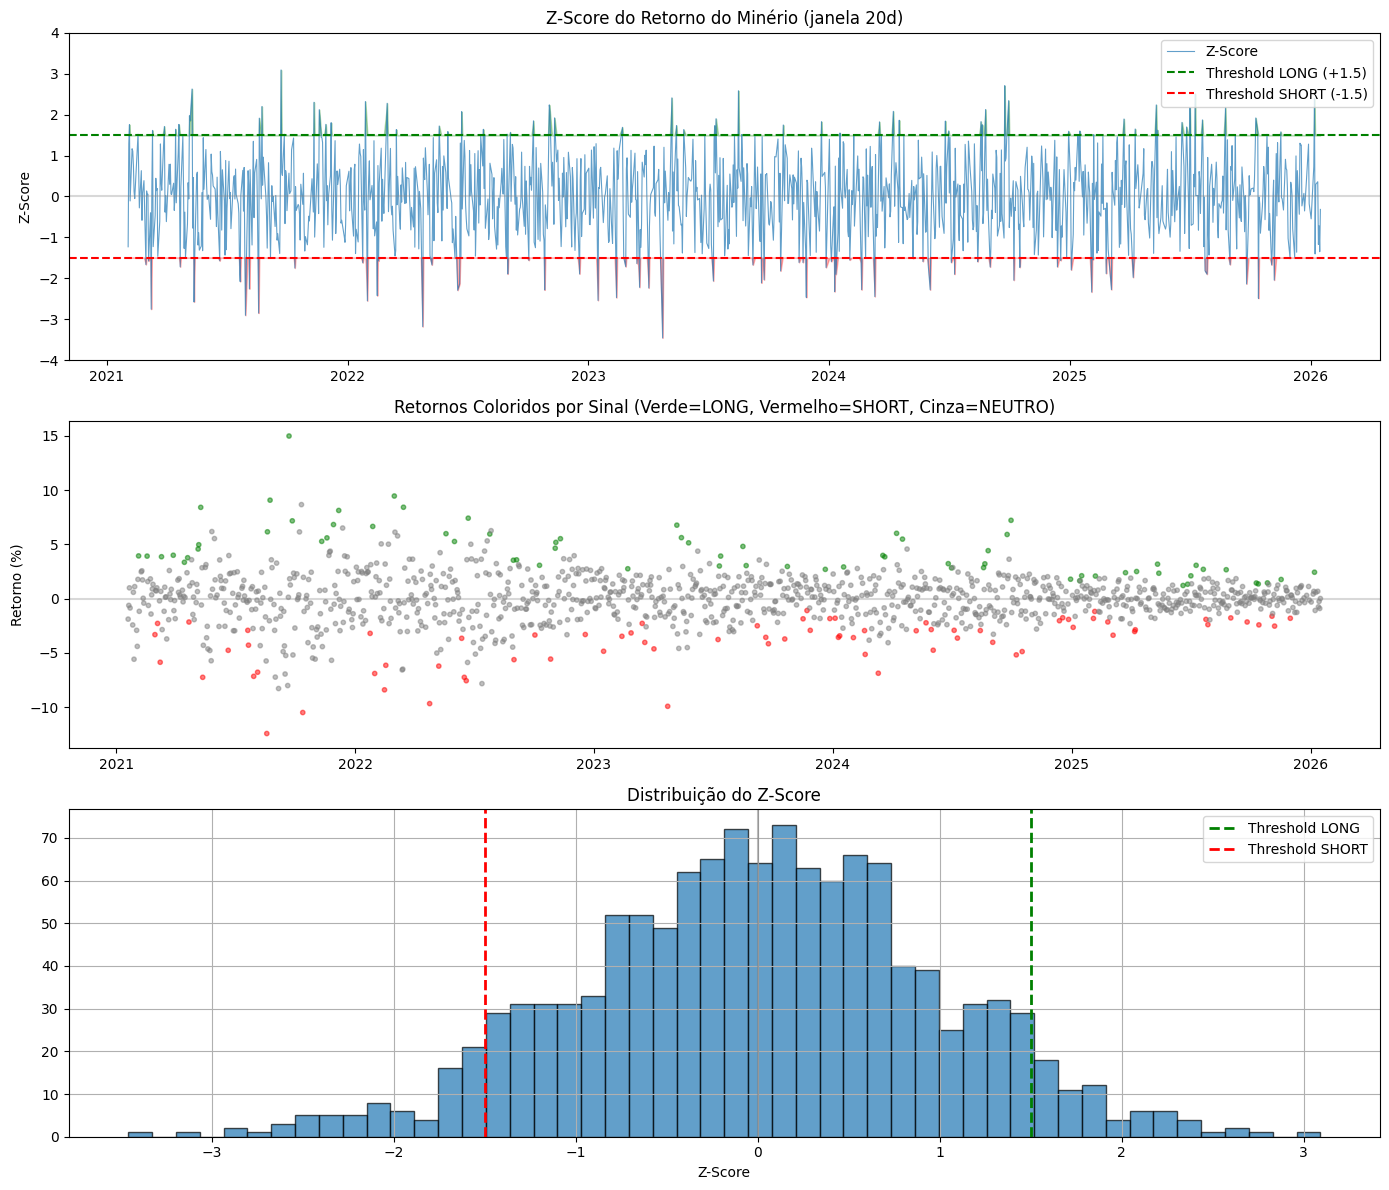

✅ Z-Score calculado corretamente!


In [11]:
# Visualização do Z-Score
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Z-Score ao longo do tempo
ax1 = axes[0]
ax1.plot(df.index, df[zscore_col], label='Z-Score', alpha=0.7, linewidth=0.8)
ax1.axhline(y=1.5, color='g', linestyle='--', label='Threshold LONG (+1.5)')
ax1.axhline(y=-1.5, color='r', linestyle='--', label='Threshold SHORT (-1.5)')
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.fill_between(df.index, 1.5, df[zscore_col].clip(lower=1.5), alpha=0.3, color='green')
ax1.fill_between(df.index, -1.5, df[zscore_col].clip(upper=-1.5), alpha=0.3, color='red')
ax1.set_title('Z-Score do Retorno do Minério (janela 20d)')
ax1.legend(loc='upper right')
ax1.set_ylabel('Z-Score')
ax1.set_ylim(-4, 4)

# Sinais gerados
ax2 = axes[1]
colors = df[signal_col].map({-1: 'red', 0: 'gray', 1: 'green'})
ax2.scatter(df.index, df['iron_return_1d'], c=colors, alpha=0.5, s=10)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.set_title('Retornos Coloridos por Sinal (Verde=LONG, Vermelho=SHORT, Cinza=NEUTRO)')
ax2.set_ylabel('Retorno (%)')

# Histograma do Z-Score
ax3 = axes[2]
df[zscore_col].hist(bins=50, ax=ax3, alpha=0.7, edgecolor='black')
ax3.axvline(x=1.5, color='g', linestyle='--', linewidth=2, label='Threshold LONG')
ax3.axvline(x=-1.5, color='r', linestyle='--', linewidth=2, label='Threshold SHORT')
ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_title('Distribuição do Z-Score')
ax3.set_xlabel('Z-Score')
ax3.legend()

plt.tight_layout()
plt.show()

print("✅ Z-Score calculado corretamente!")

## 8. Teste: Lead-Lag Correlation

TESTE: LEAD-LAG CORRELATION

Correlação Lead-Lag (Minério vs VALE3):
  lag > 0: Minério lidera VALE3
  lag < 0: VALE3 lidera Minério
  lag = 0: Simultâneo

 lag  correlation       leader
  -5    -0.026854            B
  -4    -0.027205            B
  -3     0.048820            B
  -2     0.021365            B
  -1     0.197490            B
   0     0.435505 simultaneous
   1     0.085063            A
   2    -0.024049            A
   3     0.029418            A
   4    -0.065122            A
   5     0.011036            A

✅ Maior correlação: lag=0, corr=0.4355


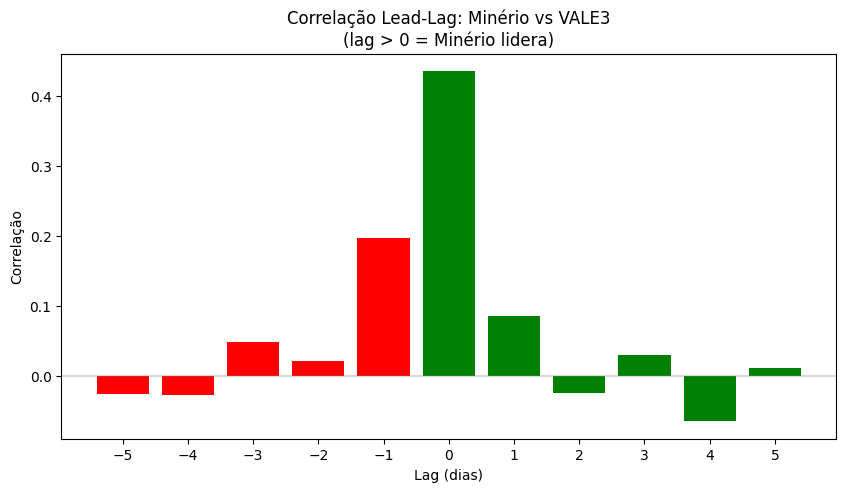

In [12]:
print("="*60)
print("TESTE: LEAD-LAG CORRELATION")
print("="*60)

# Calcula correlação lead-lag
lead_lag = calculate_lead_lag_correlation(
    df['iron_return_1d'].dropna(),
    df['vale3_return_1d'].dropna(),
    max_lag=5
)

print("\nCorrelação Lead-Lag (Minério vs VALE3):")
print("  lag > 0: Minério lidera VALE3")
print("  lag < 0: VALE3 lidera Minério")
print("  lag = 0: Simultâneo\n")
print(lead_lag.to_string(index=False))

# Melhor lag
best_lag = lead_lag.loc[lead_lag['correlation'].abs().idxmax()]
print(f"\n✅ Maior correlação: lag={int(best_lag['lag'])}, corr={best_lag['correlation']:.4f}")

# Visualização
plt.figure(figsize=(10, 5))
plt.bar(lead_lag['lag'], lead_lag['correlation'], color=['red' if x < 0 else 'green' for x in lead_lag['lag']])
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Lag (dias)')
plt.ylabel('Correlação')
plt.title('Correlação Lead-Lag: Minério vs VALE3\n(lag > 0 = Minério lidera)')
plt.xticks(lead_lag['lag'])
plt.show()

## 9. Resumo Final

In [13]:
print("="*60)
print("RESUMO FINAL - TRILHA I FEATURE ENGINEERING")
print("="*60)

# Conta features por categoria
return_cols = [c for c in df.columns if 'return' in c or 'momentum' in c or 'cumulative' in c]
vol_cols = [c for c in df.columns if 'volatility' in c or 'atr' in c or 'vol_ratio' in c]
zscore_cols = [c for c in df.columns if 'zscore' in c]
base_cols = ['iron_ore_price', 'vale3_close', 'vale3_open', 'vale3_high', 'vale3_low', 'vale3_volume', 'usd_brl', 'vix']

print(f"\nDataset final: {len(df)} registros")
print(f"Período: {df.index.min().date()} a {df.index.max().date()}")
print(f"\nFeatures criadas:")
print(f"  - Retornos:     {len(return_cols)} colunas")
print(f"  - Volatilidade: {len(vol_cols)} colunas")
print(f"  - Z-Score:      {len(zscore_cols)} colunas")
print(f"  - TOTAL:        {len(return_cols) + len(vol_cols) + len(zscore_cols)} features")

# Validação final
validation = validate_alignment(df)
print(f"\nValidação:")
print(f"  - Registros: {validation['total_rows']}")
print(f"  - Gaps > 3 dias: {validation['date_gaps']}")

missing_cols = {k: v for k, v in validation['missing_pct'].items() if v > 5}
if missing_cols:
    print(f"  - Colunas com >5% missing: {missing_cols}")
else:
    print(f"  - Todas as colunas com <5% missing ✅")

# Sinais de trading
signal_col = 'iron_return_1d_zscore_signal_20'
if signal_col in df.columns:
    sinais = df[signal_col].value_counts()
    print(f"\nSinais de trading gerados:")
    print(f"  - LONG:  {sinais.get(1, 0)} dias")
    print(f"  - SHORT: {sinais.get(-1, 0)} dias")

print("\n" + "="*60)
print("✅ TRILHA I CONCLUÍDA COM SUCESSO!")
print("="*60)

RESUMO FINAL - TRILHA I FEATURE ENGINEERING

Dataset final: 1247 registros
Período: 2021-01-18 a 2026-01-16

Features criadas:
  - Retornos:     16 colunas
  - Volatilidade: 12 colunas
  - Z-Score:      4 colunas
  - TOTAL:        32 features

Validação:
  - Registros: 1247
  - Gaps > 3 dias: 21
  - Todas as colunas com <5% missing ✅

Sinais de trading gerados:
  - LONG:  71 dias
  - SHORT: 76 dias

✅ TRILHA I CONCLUÍDA COM SUCESSO!


In [14]:
# Lista todas as colunas do DataFrame final
print("Todas as colunas do DataFrame final:")
print("-" * 40)
for i, col in enumerate(sorted(df.columns), 1):
    print(f"{i:2d}. {col}")

Todas as colunas do DataFrame final:
----------------------------------------
 1. iron_cumulative_return_20d
 2. iron_momentum_5_20
 3. iron_ore_price
 4. iron_return_10d
 5. iron_return_1d
 6. iron_return_1d_zscore_20
 7. iron_return_1d_zscore_signal_20
 8. iron_return_20d
 9. iron_return_5d
10. iron_vol_ratio_5_20
11. iron_volatility_10d
12. iron_volatility_20d
13. iron_volatility_5d
14. usd_brl
15. vale3_atr_14
16. vale3_atr_20
17. vale3_atr_pct_14
18. vale3_atr_pct_20
19. vale3_close
20. vale3_cumulative_return_20d
21. vale3_high
22. vale3_low
23. vale3_momentum_5_20
24. vale3_open
25. vale3_return_10d
26. vale3_return_1d
27. vale3_return_1d_zscore_20
28. vale3_return_1d_zscore_signal_20
29. vale3_return_20d
30. vale3_return_5d
31. vale3_vol_ratio_5_20
32. vale3_volatility_10d
33. vale3_volatility_20d
34. vale3_volatility_5d
35. vale3_volume
36. vix


In [15]:
# Amostra dos dados finais
print("Amostra dos dados finais (últimas 5 linhas):")
display(df.tail())

Amostra dos dados finais (últimas 5 linhas):


,iron_ore_price,vale3_close,vale3_open,vale3_high,vale3_low,vale3_volume,usd_brl,vix,iron_return_1d,iron_return_5d,...,vale3_volatility_20d,vale3_atr_14,vale3_atr_pct_14,vale3_atr_20,vale3_atr_pct_20,vale3_vol_ratio_5_20,iron_return_1d_zscore_20,iron_return_1d_zscore_signal_20,vale3_return_1d_zscore_20,vale3_return_1d_zscore_signal_20
2026-01-12,109.18,74.74,75.00,75.47,74.51,13129800.0,5.3703,15.12,0.663839,3.223977,...,1.239419,1.447857,1.937192,1.4100,1.886540,1.598380,0.359015,0,-0.468452,0
2026-01-13,108.34,75.35,74.47,76.05,74.28,24539200.0,5.3737,15.98,-0.769372,1.756363,...,1.206544,1.506429,1.999242,1.4240,1.889847,0.737054,-1.173629,0,0.215468,0
2026-01-14,108.05,78.92,75.84,79.09,75.64,44225300.0,5.3713,16.75,-0.267676,-0.917011,...,1.521439,1.732143,2.194808,1.5205,1.926635,1.573906,-0.717248,0,2.636123,1
2026-01-15,107.06,78.85,78.90,79.64,78.51,35503900.0,5.3961,15.84,-0.916242,-0.732499,...,1.529322,1.630000,2.067216,1.5140,1.920101,1.484805,-1.350123,0,-0.521517,0
2026-01-16,107.06,78.85,78.90,79.64,78.51,35503900.0,5.3683,15.84,0.000000,-1.290798,...,1.537464,1.642857,2.083522,1.5260,1.935320,1.344409,-0.316951,0,-0.441156,0
